## Initialize Input Files for IPMOF (initialize_IPMOF.py)

### Initialize necessary information

1. Read FF_Parameters excel file to get force field parameters for atoms
2. Initialize force field selection, cutOff radius and grid size for energy map

### Create input files for MOF files in a given directory
1. Reaf MOF files in ".mol2" format from given directory and create a list
2. Choose the first MOF1 as the stationary (map) MOF, initialize its variables, and calculate packed coordinates
3. For all the MOFs in the list:
4. Initialize MOF2 variables for the mobile MOF
5. Calculate energy map
6. Export energy map -> .json
7. Export MOF2 structure information -> .json

In [9]:
import math
import os
os.chdir('C:\Kutay\IPMOF')
from energyMapFunctions import *

# Initialize force field parameters
excelFileDir = 'C:\\Users\\kutay\\iPython\\IPMOF\\FF_Parameters.xlsx'
UFF = readFFparameters(excelFileDir, 'UFF')
cutOff = 13

# Generate MOF list
fileDir = 'C:\\Users\\kutay\\iPython\\IPMOF\\multipleMOF'
fileFormat = ".mol2"
MOFlist = generateMOFlist(fileDir, fileFormat)
print(MOFlist)

MOFselection = 2
MOF2 = MOF()
MOF2.dir = fileDir + '\\' + MOFlist[MOFselection]
MOF2.file = open(MOF2.dir, 'r')
MOF2.initialize()
MOF2.initializeFF(UFF)
print(MOFlist[MOFselection] + ' has been initialized')

['Cd2HC9NO8-Extended.mol2', 'Cd2HC9NO8.mol2', 'MOF5.mol2', 'Zn4H12C24O13-Extended.mol2', 'Zn4H12C24O13.mol2']
MOF5.mol2 has been initialized


In [3]:
# Calculate packing for stationary MOF
#packingFactor = [1, 2, 3]
packingFactor = Packing.factor(MOF2.UCsize, cutOff)
print('Packing factor calculated as: ' + str(packingFactor))
translationVectors, UCvectors = Packing.vectors(packingFactor, MOF2.UCsize, MOF2.UCangle)
MOF2.packedCoor = Packing.UC(translationVectors, packingFactor, UCvectors, MOF2.atomCoor)

Packing factor calculated as: [3, 3, 3]


In [4]:
atomList = {}
atomList['sigma'] = MOF2.sigma
atomList['epsilon'] = MOF2.epsilon

In [5]:
# Calculate Energy Map
eMap = energyMap(MOF2, atomList, cutOff, 1)

In [45]:
# Create export directory for the energy map
MOFname = MOFlist[MOFselection].split('.')[0]
exportFolder = "C:\\Users\\kutay\\iPython\\IPMOF\\multipleMOF"
exportFormat = ".json"
exportDir_eMap = os.path.join(exportFolder, MOFname + '_eMap' + exportFormat)
exportDir_MOF = os.path.join(exportFolder, MOFname + exportFormat)
print(exportDir_eMap)
print(exportDir_MOF)

C:\Users\kutay\iPython\IPMOF\multipleMOF\MOF5_eMap.json
C:\Users\kutay\iPython\IPMOF\multipleMOF\MOF5.json


In [46]:
# var eMap = JSON.parse(fs.readFileSync('MOF5_eMap.json', 'utf8'));
import json

# Convert energy map array into list
eMap2 = eMap.tolist()
# Export energy map list to json file 
with open(exportDir_eMap, 'w') as outfile:
    json.dump(eMap2, outfile)

In [47]:
# Export coordinates of mobile MOF to json file
with open(exportDir_MOF, 'w') as outfile:
    json.dump(MOF2.atomCoor, outfile)
    
# need more information about MOFs for the simulation (export json object??)

Populating the interactive namespace from numpy and matplotlib


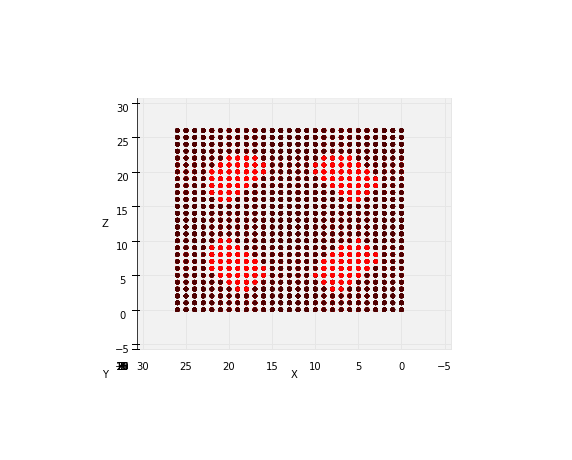

In [10]:
plotEnergyMap(eMap, 90, 0)

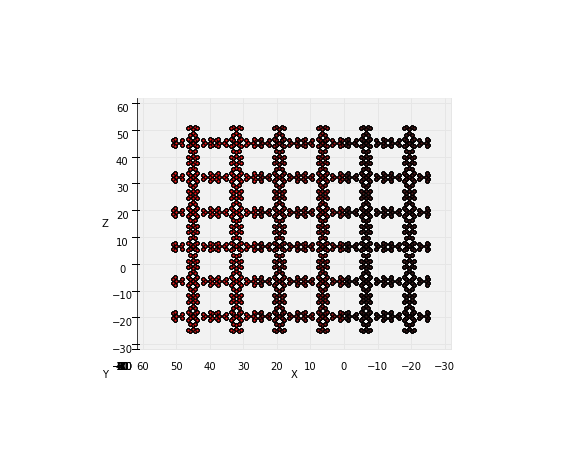

In [84]:
plotPackedCell(MOF2.packedCoor, 90, 0)

In [15]:

eMapDir = "C:\\Users\\kutay\\iPython\\IPMOF\\eMap.js"
eMapFile = open(eMapDir, 'w')
eMapFile.write("var eMap = [];\n")
eMapIndex = 0
for line in eMap:
    eMapFile.write("eMap[" + str(eMapIndex) + "] = ")
    eMapFile.write("[" + str(line[0]) + ", ")
    eMapFile.write(str(line[1]) + ", ")
    eMapFile.write(str(line[2]) + ", ")
    eMapFile.write(str(line[3]) + "];\n")
    eMapIndex += 1
eMapFile.close()

In [41]:
# Sort energy map according to energy values
sortedMap = sorted(eMap, key=lambda x: x[3], reverse=True)
energyLimit = sortedMap[len(MOF2.atomCoor)][3]